In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import plotly.express as px
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.simplefilter('ignore')
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from imblearn.combine import SMOTETomek
import shap 
pd.set_option('display.max_columns',30)

In [3]:
train = pd.read_csv('Cleaned_data/Train_dataset.csv', index_col=0)
test = pd.read_csv('Cleaned_data/Test_dataset.csv', index_col=0)
#test = pd.read_csv('Cleaned_data/New_test_dataset.csv', index_col=0)

In [4]:
train.drop(columns = ['date_x','serial_number','model','failure_x','date_actual_fail'], inplace=True)
test.drop(columns = ['date_x','serial_number','model','failure_x','date_actual_fail','new_date'], inplace=True)
train.head()
train['failure_actual_fail'].value_counts()

0    31277
1      836
Name: failure_actual_fail, dtype: int64

# Method 2 split data - Using train_test_split directly

In [5]:
train_features = train.drop(columns=['failure_actual_fail'])
train_y = train[['failure_actual_fail']]
test_features = test.drop(columns=['failure_actual_fail'])
test_y = test[['failure_actual_fail']]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_y, test_size=0.3, random_state = 1)
X_test, test_features, y_test, test_y =  train_test_split(X_test, y_test, test_size=0.5, random_state = 1)

In [7]:
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)
# print(test_features.shape)
# print(test_y.shape)

In [8]:
# print(y_train['failure_actual_fail'].value_counts())
# print(y_test['failure_actual_fail'].value_counts())
# print(test_y['failure_actual_fail'].value_counts())

## Creating balanced training set (Equal fails and no fails)

### Using pacakge

In [9]:
#basic over sample (5:1 negative-positive)
basicOS = RandomOverSampler(sampling_strategy=0.05, random_state=23311) #can set the proportion of minority/total 
train_basicOS, label_basicOS = basicOS.fit_resample(X_train,y_train)

#smote over sample (5:1 negative-positive)
smoteOS = SMOTE(sampling_strategy=0.33) #can set the proportion of minority/total
train_smoteOS, label_smoteOS = smoteOS.fit_resample(X_train,y_train)

#basic under sample
basicUS = RandomUnderSampler(sampling_strategy=0.33)
train_basicUS,label_basicUS = basicUS.fit_resample(X_train,y_train)

print(X_train.shape)
print(y_train.value_counts())

print(train_basicOS.shape)
print(label_basicOS.value_counts())

print(train_smoteOS.shape)
print(label_smoteOS.value_counts())

print(train_basicUS.shape)
print(label_basicUS.value_counts())

(22479, 25)
failure_actual_fail
0                      21923
1                        556
dtype: int64
(23019, 25)
failure_actual_fail
0                      21923
1                       1096
dtype: int64
(29157, 25)
failure_actual_fail
0                      21923
1                       7234
dtype: int64
(2240, 25)
failure_actual_fail
0                      1684
1                       556
dtype: int64


In [10]:
from sklearn.metrics import recall_score
def FNR_calc(mat):
    tn = mat[0,0]
    tp = mat[1,1]
    fn = mat[1,0]
    fp = mat[0,1]
    print(f'tn: {tn}, fp: {fp},\nfn: {fn},   tp: {tp}')
    print(f'FNR: {round(fn/(fn+tp) * 100, 2)}%')
    print(f'Recall: {round(tp/(fn+tp) * 100, 2)}%')
    print(f'Precision: {round(tp/(fp+tp) * 100, 2)}%')
    return fn/(fn+tp)

def matrix_plotter(mat):
    ax = sns.heatmap(mat, annot=True, cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()

## Training Models - XGBoost mainly with hyperparameter tuning

tn: 4669, fp: 4,
fn: 78,   tp: 66
FNR: 54.17%
Recall: 45.83%
Precision: 94.29%


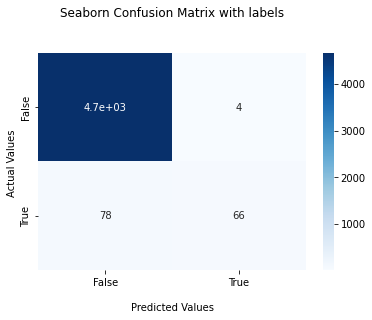

In [11]:
xgbc = XGBClassifier(verbosity = 0)
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
#print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

tn: 4632, fp: 41,
fn: 54,   tp: 90
FNR: 37.5%
Recall: 62.5%
Precision: 68.7%


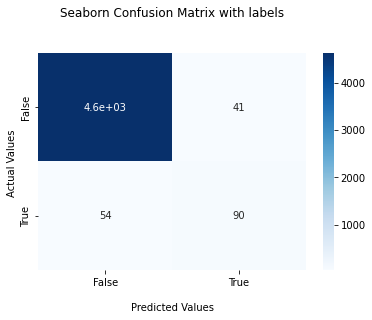

In [12]:
basicOS = RandomOverSampler(sampling_strategy=1, random_state = 2331) #can set the proportion of minority/total 
train_basicOS, label_basicOS = basicOS.fit_resample(X_train,y_train)

xgbc = xgb.XGBClassifier(verbosity = 0)
xgbc.fit(train_basicOS, label_basicOS)
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
#print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

tn: 4634, fp: 39,
fn: 59,   tp: 85
FNR: 40.97%
Recall: 59.03%
Precision: 68.55%


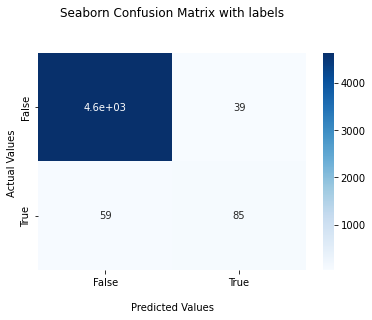

In [13]:
basicOS = RandomOverSampler(sampling_strategy=0.8, random_state=23311) #can set the proportion of minority/total 
train_basicOS, label_basicOS = basicOS.fit_resample(X_train,y_train)

xgbc = XGBClassifier(verbosity = 0)
xgbc.fit(train_basicOS, label_basicOS )
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
#print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

tn: 4644, fp: 29,
fn: 59,   tp: 85
FNR: 40.97%
Recall: 59.03%
Precision: 74.56%


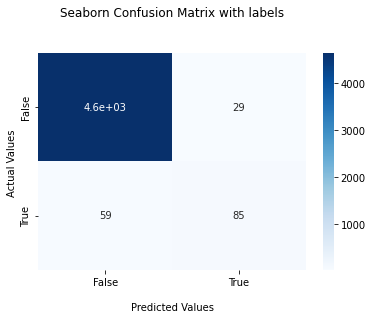

In [14]:
basicOS = RandomOverSampler(sampling_strategy=0.5, random_state=23311) #can set the proportion of minority/total 
train_basicOS, label_basicOS = basicOS.fit_resample(X_train,y_train)

xgbc = XGBClassifier(verbosity = 0)
xgbc.fit(train_basicOS, label_basicOS )
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
#print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

tn: 4645, fp: 28,
fn: 60,   tp: 84
FNR: 41.67%
Recall: 58.33%
Precision: 75.0%


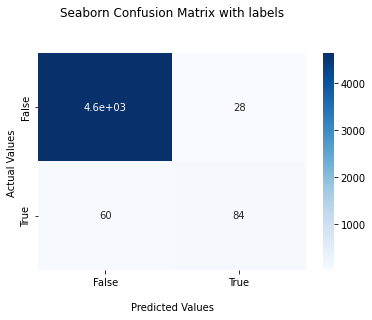

In [15]:
basicOS = RandomOverSampler(sampling_strategy=0.33, random_state=23311) #can set the proportion of minority/total 
train_basicOS, label_basicOS = basicOS.fit_resample(X_train,y_train)

xgbc = xgb.XGBClassifier(verbosity = 0)
xgbc.fit(train_basicOS, label_basicOS )
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
#print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

tn: 4663, fp: 10,
fn: 67,   tp: 77
FNR: 46.53%
Recall: 53.47%
Precision: 88.51%


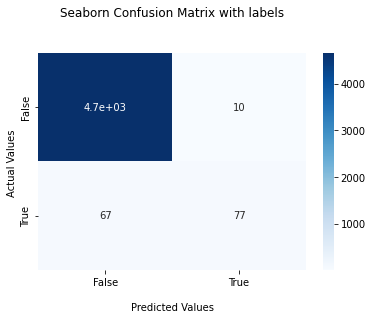

In [16]:
basicOS = RandomOverSampler(sampling_strategy=0.1, random_state=23311) #can set the proportion of minority/total 
train_basicOS, label_basicOS = basicOS.fit_resample(X_train,y_train)

xgbc = xgb.XGBClassifier(verbosity = 0)
xgbc.fit(train_basicOS, label_basicOS )
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
#print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

## Hyperparameter

tn: 4630, fp: 43,
fn: 59,   tp: 85
FNR: 40.97%
Recall: 59.03%
Precision: 66.41%


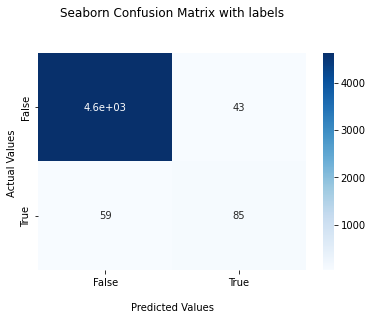

In [17]:
basicOS = RandomOverSampler(sampling_strategy=1, random_state=233431) #can set the proportion of minority/total 
train_basicOS, label_basicOS = basicOS.fit_resample(X_train,y_train)

xgbc = XGBClassifier(verbosity = 0)
xgbc.fit(train_basicOS, label_basicOS)
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
#print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

Learning rate

In [18]:
param_test7 = {
 'learning_rate':[0.05,0.1,0.3,0.5,1]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier(
 objective= 'binary:logistic', nthread=2, scale_pos_weight=1, seed=27), 
 param_grid = param_test7, scoring='recall',n_jobs=2,cv=4)
gsearch7.fit(train_basicOS, label_basicOS)
gsearch7.best_params_, gsearch7.best_score_

({'learning_rate': 0.3}, 1.0)

tn: 4630, fp: 43,
fn: 59,   tp: 85
FNR: 40.97%
Recall: 59.03%
Precision: 66.41%


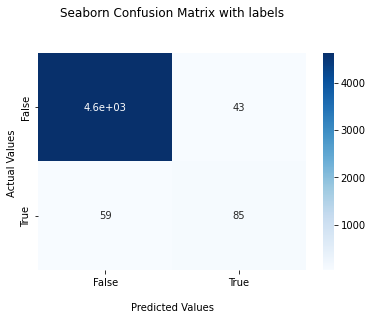

In [19]:
xgbc = gsearch7.best_estimator_
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

In [20]:
param_test1 = {
 'max_depth':range(5,11,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(
 objective= 'binary:logistic', nthread=2, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='recall',n_jobs=2, cv=4)
gsearch1.fit(train_basicOS, label_basicOS)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'min_child_weight': 5}, 1.0)

tn: 4590, fp: 83,
fn: 50,   tp: 94
FNR: 34.72%
Recall: 65.28%
Precision: 53.11%


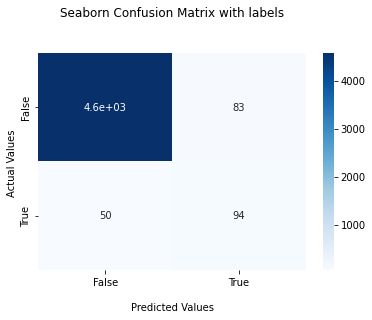

In [21]:
xgbc = gsearch1.best_estimator_
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

n_estimators

In [22]:
param_test8 = {
 'n_estimators':[50,200,400,500]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier(
 objective= 'binary:logistic', nthread=2, scale_pos_weight=1, seed=27), 
 param_grid = param_test8, scoring='recall',n_jobs=2,cv=4)
gsearch8.fit(train_basicOS, label_basicOS)
gsearch8.best_params_, gsearch8.best_score_

({'n_estimators': 200}, 1.0)

In [23]:
gsearch8.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=2, nthread=2,
              num_parallel_tree=1, predictor='auto', random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

tn: 4658, fp: 23,
fn: 48,   tp: 88
FNR: 35.29%
Recall: 64.71%
Precision: 79.28%


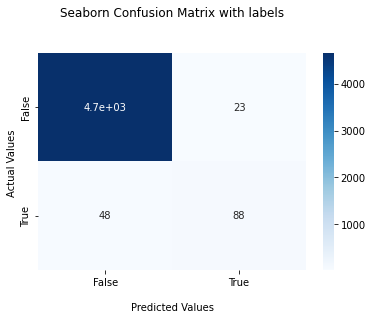

In [24]:
xgbc = gsearch8.best_estimator_
y_pred = xgbc.predict(test_features)
cf_matrix = confusion_matrix(test_y, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

Tune gamma

In [25]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(
 objective= 'binary:logistic', nthread=2, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='recall',n_jobs=2, cv=4)
gsearch3.fit(train_basicOS, label_basicOS)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 1.0)

tn: 4630, fp: 43,
fn: 59,   tp: 85
FNR: 40.97%
Recall: 59.03%
Precision: 66.41%


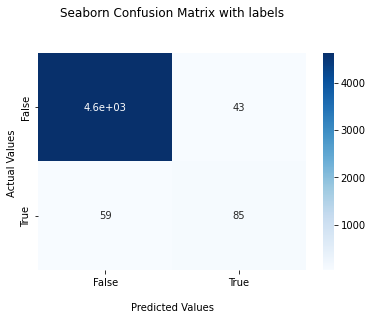

In [26]:
xgbc = gsearch3.best_estimator_
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

Tune subsample and colsample_bytree

In [27]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='recall',n_jobs=2, cv=4)
gsearch4.fit(train_basicOS, label_basicOS)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.6}, 1.0)

tn: 4622, fp: 51,
fn: 57,   tp: 87
FNR: 39.58%
Recall: 60.42%
Precision: 63.04%


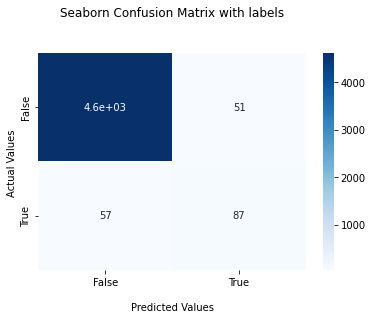

In [28]:
xgbc = gsearch4.best_estimator_
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

Tuning Regularization Parameters

In [29]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test5, scoring='recall',n_jobs=2,cv=4)
gsearch5.fit(train_basicOS, label_basicOS)
gsearch5.best_params_, gsearch5.best_score_

({'reg_alpha': 1e-05}, 1.0)

tn: 4630, fp: 43,
fn: 59,   tp: 85
FNR: 40.97%
Recall: 59.03%
Precision: 66.41%


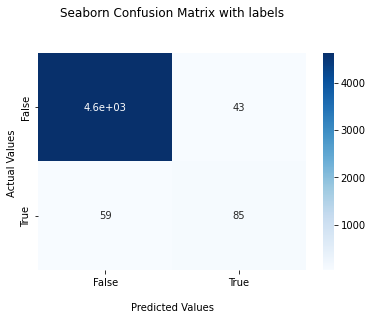

In [30]:
xgbc = gsearch5.best_estimator_
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

tn: 4512, fp: 161,
fn: 40,   tp: 104
FNR: 27.78%
Recall: 72.22%
Precision: 39.25%


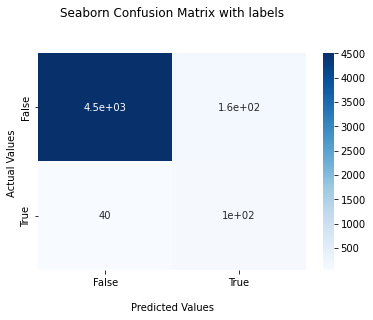

In [46]:
xgbc = XGBClassifier(objective= 'binary:logistic', scale_pos_weight=1, seed=27, learning_rate = 0.3, 
max_depth=5, min_child_weight=5, n_estimators=200, gamma=0, colsample_bytree=0.6, subsample=0.6, reg_alpha=25)
xgbc.fit(train_basicOS,label_basicOS)
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

tn: 4509, fp: 172,
fn: 30,   tp: 106
FNR: 22.06%
Recall: 77.94%
Precision: 38.13%


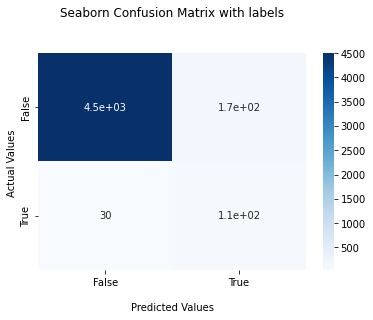

In [47]:
y_pred = xgbc.predict(test_features)
cf_matrix = confusion_matrix(test_y, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)